In [1]:
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.ticker import AsinhLocator, ScalarFormatter
from matplotlib.transforms import offset_copy
from matplotlib.patheffects import withStroke

#from colaml import *
from myconfig import DATA_DIR, ROOT_DIR

In [2]:
%matplotlib inline

In [3]:
mm = 1 / 25.4
colors = dict(
    plainEM         = '#ABABAB', 
    parabolicEMorig = '#006BA4', 
    parabolicEMmod  = '#FF800E', 
)

In [4]:
logs = pd.read_csv(
    ROOT_DIR/'results'/'misc-EMacc-logs1.tsv.gz', sep='\t', index_col=[0,1,2]
)
params = pd.read_csv(
    ROOT_DIR/'results'/'misc-EMacc-logs2.tsv.gz', sep='\t', index_col=[0,1,2], header=[0,1]
)

In [5]:
num_iter = logs.groupby(level=(0,1)).size().unstack().T.reindex(colors.keys())

In [6]:
print(num_iter.T.eval('parabolicEMorig / plainEM').mean())
print(num_iter.T.eval('parabolicEMmod / parabolicEMorig').mean())

0.7402172694063054
0.6485131332884917


In [7]:
print(wilcoxon(num_iter.loc['plainEM'], num_iter.loc['parabolicEMorig']))
print(wilcoxon(num_iter.loc['parabolicEMorig'], num_iter.loc['parabolicEMmod']))

WilcoxonResult(statistic=0.0, pvalue=0.001953125)
WilcoxonResult(statistic=6.0, pvalue=0.02734375)


In [8]:
ss = StandardScaler()
pca = PCA(n_components=10)

param_pcs = (
    pd.DataFrame(
        pca.fit_transform(ss.fit_transform(params)), 
        index=logs.index
    )
    .rename(columns=lambda i: f'PC{i+1}')
    .pipe(pd.merge, logs, left_index=True, right_index=True)
)
conv_mean = param_pcs.xs('plainEM', level=1).groupby(level=0).tail(1).mean(numeric_only=True)

In [9]:
def draw_loglik(ax):
    for method in ('plainEM', 'parabolicEMorig', 'parabolicEMmod'):
        for rep in range(1, 11):
            tmp = logs.xs((rep, method), level=(0,1))
            mask = tmp['status'].eq('acc-search') & tmp['status'].shift(-1).eq('stdEM')
            tmp = tmp[~mask]
            
            tmp['loglik'].plot(c=colors[method], alpha=0.8, lw=0.75, ax=ax)

            tmp['loglik'].iloc[-1:].plot(marker=2, ms=3, lw=5, c=colors[method], ax=ax)
            ax.annotate(
                rep, *tmp['loglik'].iloc[-1:].items(), xytext=(-0.5, 8), textcoords='offset points', 
                ha='center', va='top', size='xx-small', c=colors[method], 
                path_effects=[withStroke(linewidth=0.5, foreground='w')]
            )

    else:
        for rep in range(1, 11):
            tmp = logs.xs((rep, method), level=(0,1))
            tmp['loglik'].iloc[:1].plot(marker=5, ms=5, mfc='k', mec='w', mew=0.3, ax=ax)
            ax.annotate(
                rep, *tmp['loglik'].iloc[:1].items(), xytext=(-5, 0), textcoords='offset points', 
                ha='right', va='center', size='xx-small', c='k', 
                path_effects=[withStroke(linewidth=0.3, foreground='w')]
            )

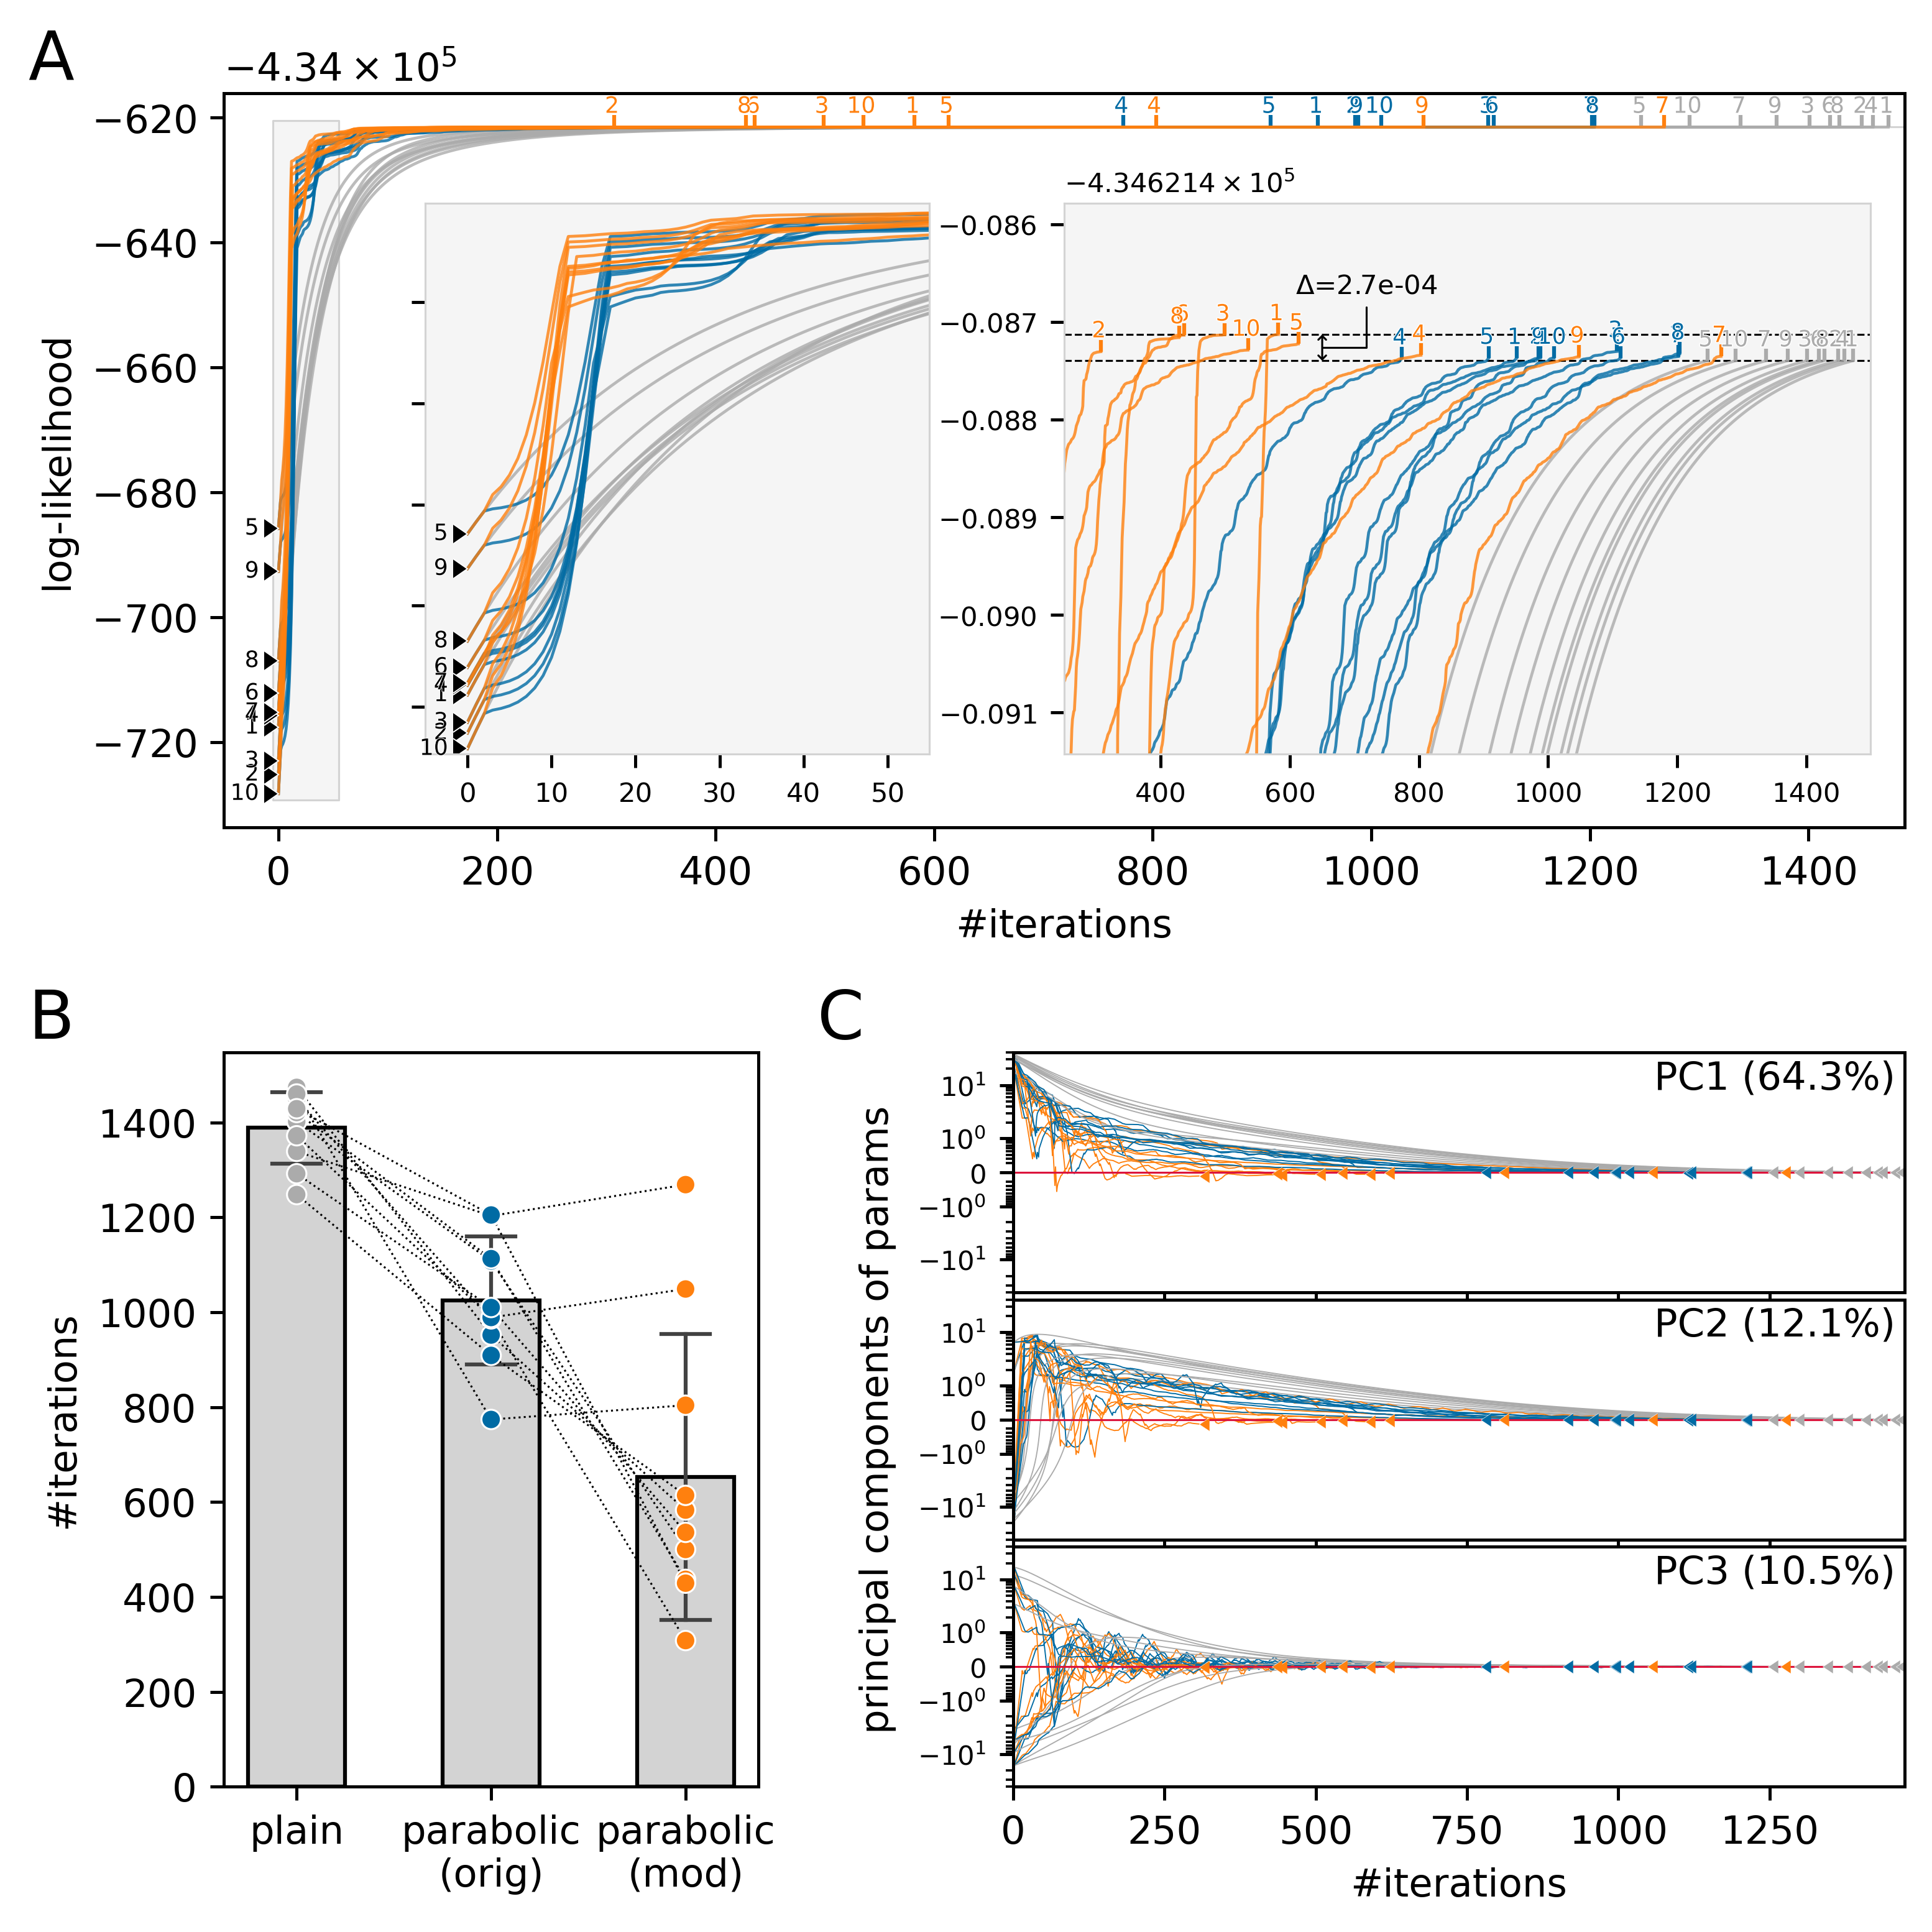

In [10]:
with plt.rc_context({'axes.formatter.offset_threshold': 3}):
    fig, axd = plt.subplot_mosaic(
        'AA\nBC', gridspec_kw=dict(width_ratios=[3,5]), 
        figsize=(178*mm, 178*mm), dpi=450, layout='tight'
    )
    ax = axd['A']
    axins1 = ax.inset_axes([0.12, 0.10, 0.30, 0.75])
    axins2 = ax.inset_axes([0.50, 0.10, 0.48, 0.75])

draw_loglik(ax)
ax.margins(x=0.01, y=0.04)
ax.set_xlim(left=-50)
ax.set_xlabel('#iterations')
ax.set_ylabel('log-likelihood')
ax.yaxis.get_major_formatter().set_useMathText(True)

draw_loglik(axins1)
axins1.set_xlim(-5, 55)
axins1.margins(y=0.01)
axins1.tick_params(labelsize='x-small', labelleft=False)
axins1.spines[:].set_color('lightgray')
axins1.spines[:].set_linewidth(0.5)
axins1.set_facecolor('whitesmoke')

draw_loglik(axins2)
axins2.set_xlim(250, 1500)
y0, y1 = logs.groupby(level=(0,1))['loglik'].last().agg([min, max])
axins2.set_ylim(y0 - (y1 - y0) * 15, y1 + (y1 - y0) * 5)
axins2.axhline(y0, color='k', ls='--', lw=0.5, zorder=0)
axins2.axhline(y1, color='k', ls='--', lw=0.5, zorder=0)

axins2.tick_params(labelsize='x-small')
axins2.spines[:].set_color('lightgray')
axins2.spines[:].set_linewidth(0.5)
axins2.set_facecolor('whitesmoke')
axins2.yaxis.get_offset_text().set_fontsize('x-small')
axins2.yaxis.get_major_formatter().set_useMathText(True)
axins2.annotate(
    '', (650, y1), (650, y0), 
    arrowprops=dict(
        arrowstyle='<->,head_length=0.1,head_width=0.1', 
        linewidth=0.5, shrinkA=0, shrinkB=0)
)
axins2.annotate(
    f'$\Delta$={y1 - y0:.1e}', 
    (650, (y0 + y1) / 2), 
    (-1, 2), 
    textcoords='offset fontsize', 
    arrowprops=dict(
        arrowstyle='-', linewidth=0.5, shrinkA=0, shrinkB=0,
        connectionstyle='angle,angleA=-90,angleB=180,rad=0'
    ),
    fontsize='x-small'
)

ax.fill_between(axins1.get_xlim(), *axins1.get_ylim(), ec='lightgray', fc='whitesmoke', lw=0.5)
ax.fill_between(axins2.get_xlim(), *axins2.get_ylim(), ec='lightgray', fc='whitesmoke', lw=0.5)

ax = axd['B']

sns.barplot(
    num_iter.T, estimator='mean', width=0.5, errorbar='sd', capsize=0.25, errwidth=1, ax=ax, 
    order=['plainEM', 'parabolicEMorig', 'parabolicEMmod'], 
    lw=1, ec='k', fc='lightgray', 
)
sns.stripplot(
    num_iter.T, jitter=False, ax=ax, 
    order=colors.keys(), palette=colors.values(), edgecolor='w', linewidth=0.5
)
num_iter.plot(ls=':', lw=0.5, ms=5, c='k', legend=False, ax=ax)
ax.set_xticklabels(['plain', 'parabolic\n(orig)', 'parabolic\n(mod)'])
ax.set_ylabel('#iterations')

axd['C'].spines[:].set_visible(False)
axd['C'].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
axd['C'].set_facecolor('none')
gs = GridSpecFromSubplotSpec(3, 1, axd['C'].get_subplotspec(), hspace=0.03)
axesC = gs.subplots(sharex=True, sharey=True)

for i, ax in enumerate(axesC.flat, start=1):
    # paths
    for (rep, method), grp in param_pcs.groupby(level=(0,1)):
        (
            (grp[f'PC{i}'] - conv_mean[f'PC{i}'])
            .loc[grp['status'].eq('stdEM')]
            .xs((rep, method), level=(0,1)).loc[0:]
        ).plot(
            ax=ax, c=colors[method], label=method, legend=False, lw=0.3, zorder=0
        )#, alpha=0.1)

    # endpoints
    for method, grp in param_pcs.groupby(level=1):
        (
            (grp[f'PC{i}'] - conv_mean[f'PC{i}'])
            .groupby(level=0, group_keys=False)
            .apply(lambda subgrp: subgrp.iloc[-1:])
            .rename_axis([None, None, '#iterations'])
            .reset_index(level=2)
        ).plot.scatter(
            x='#iterations', y=f'PC{i}', marker=4, c=colors[method], ec='w', lw=0.1, s=12, ax=ax, zorder=2
        )
        
    ax.text(0.99, 0.97, f'PC{i} ({pca.explained_variance_ratio_[i-1]:.1%})', ha='right', va='top', transform=ax.transAxes)
    ax.axhline(0, color='crimson', lw=0.5, zorder=1)
    ax.margins(0)
    ax.set_ylim(-40, 40)
    ax.set_yscale('asinh', linear_width=0.5, subs=range(2,10))
    ax.yaxis.set_major_locator(AsinhLocator(linear_width=0.5, numticks=4, symthresh=1))
    ax.yaxis.set_tick_params(labelsize='x-small')
    ax.set_ylabel(None)
    
else:
    axd['C'].set_ylabel('principal components of params', labelpad=30)

for idx, ax in axd.items():
    ax.text(
        0, 1, idx, size='xx-large', 
        transform=offset_copy(ax.transAxes, fig=fig, x=-0.7, y=0.05)
    )
    
fig.savefig('jpg/misc-EMacc.jpg', bbox_inches='tight', dpi=350)
fig.savefig('png/misc-EMacc.png', bbox_inches='tight', dpi=350)
fig.savefig('pdf/misc-EMacc.pdf', bbox_inches='tight')